In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_wine

%matplotlib inline

In [2]:
plt.rcParams["figure.figsize"] = (12,9)

# Read the data

In [3]:
wine_data = load_wine()

wine_df = pd.DataFrame(
    data=wine_data.data,
    columns=wine_data.feature_names
)

wine_df['target'] = wine_data.target

wine_df.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:3399: UserWarning: 8.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


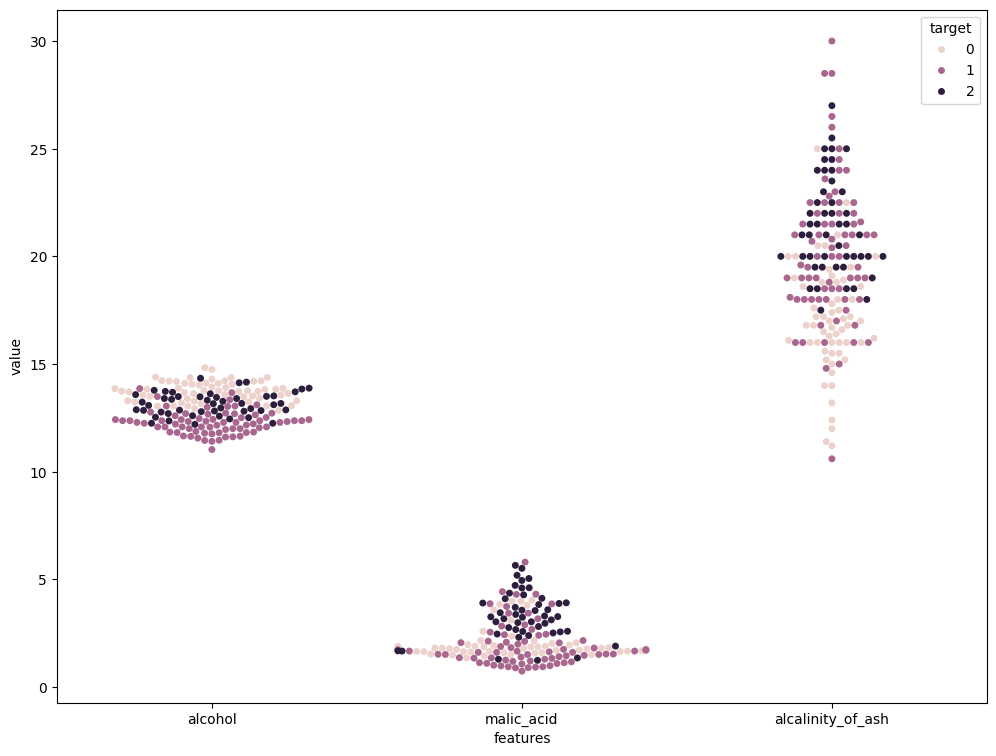

In [4]:
from seaborn import swarmplot

data_to_plot = pd.melt(wine_df[['alcohol', 'malic_acid', 'alcalinity_of_ash', 'target']],
                       id_vars='target',
                       var_name='features',
                       value_name='value')

swarmplot(data=data_to_plot, x='features', y='value', hue='target');

In [5]:
wine_df['target'].value_counts()

,count
target,
1,71
0,59
2,48


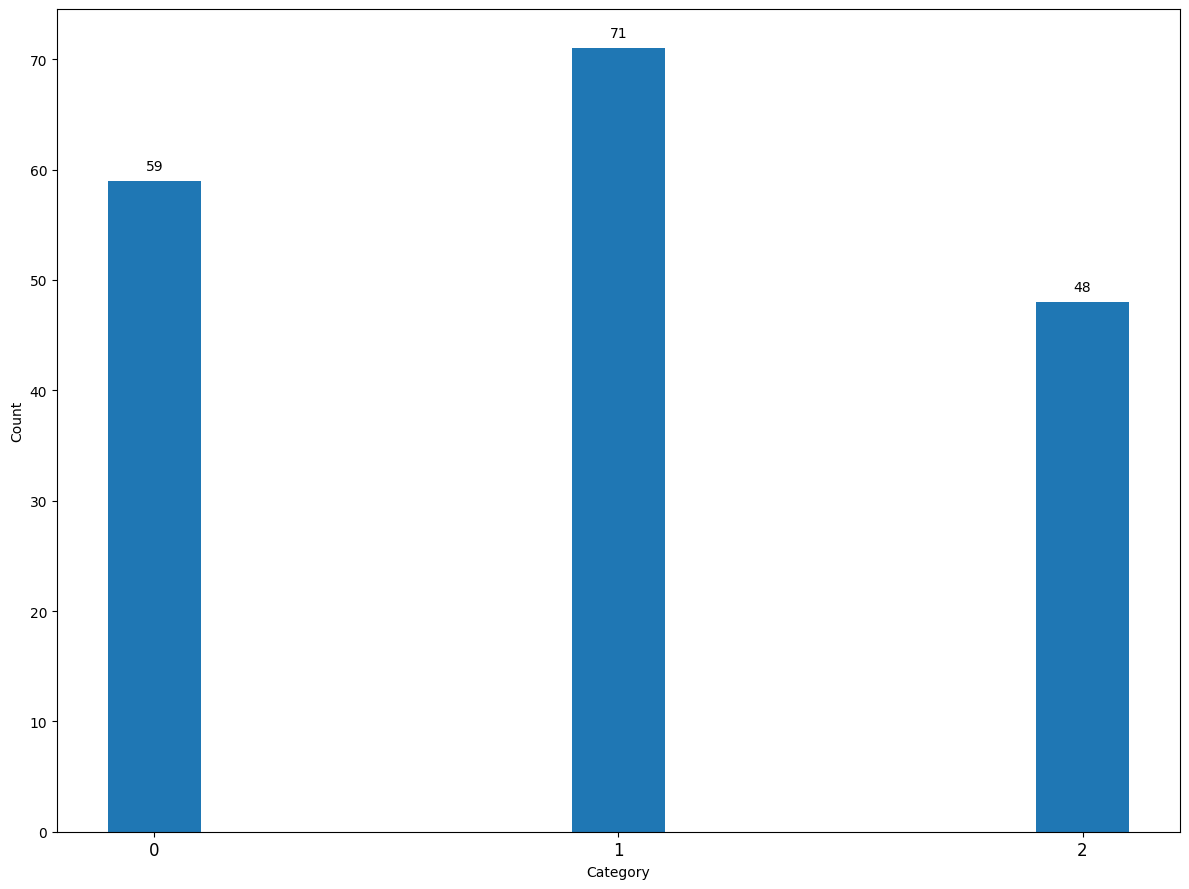

In [6]:
fig, ax = plt.subplots()

x = [0, 1, 2]
y = [59, 71, 48]

ax.bar(x, y, width=0.2)
ax.set_xlabel('Category')
ax.set_ylabel('Count')
ax.set_xticks([0,1,2])
ax.set_xticklabels([0,1,2], fontsize=12)

for index, value in enumerate(y):
    plt.text(x=int(index), y=value+1, s=str(value), ha='center')

plt.tight_layout()

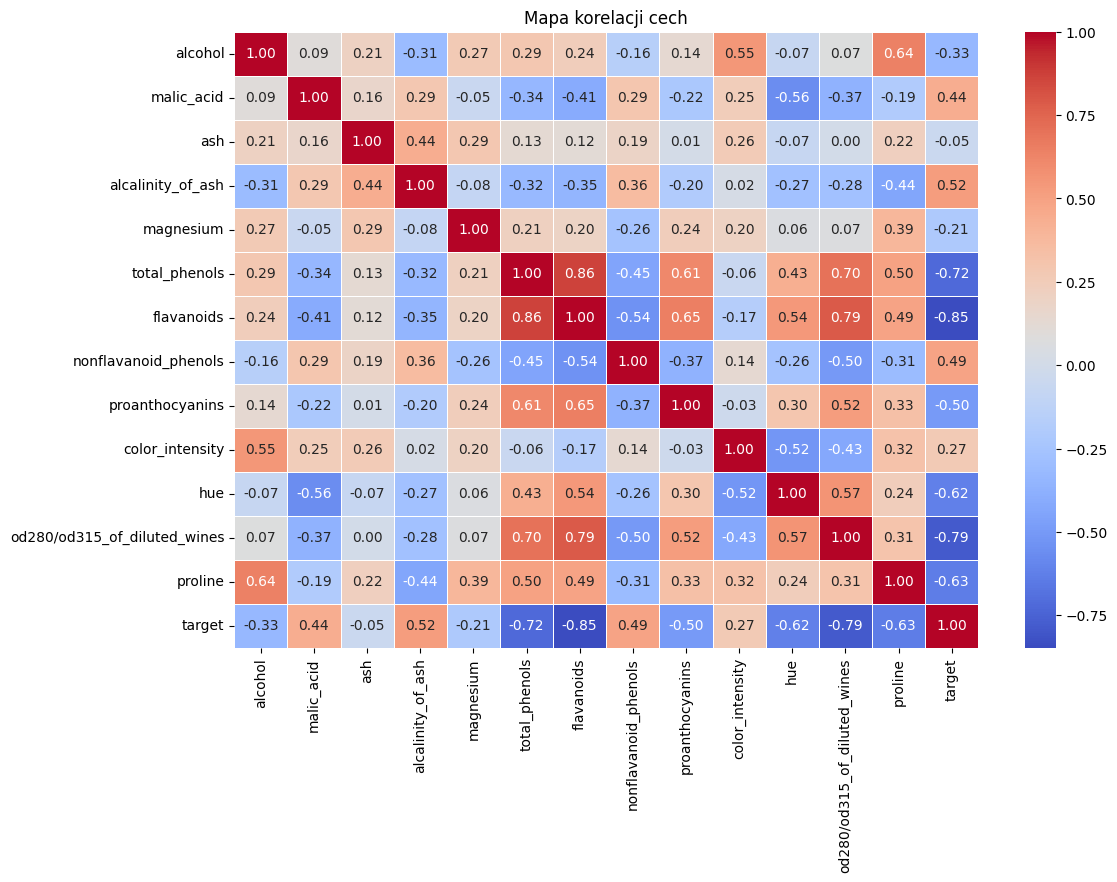

In [8]:
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.heatmap(wine_df.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Mapa korelacji cech")
plt.show()


# Train/test split

In [ ]:
from sklearn.model_selection import train_test_split

X = wine_df.drop(['target'], axis=1)
y = wine_df['target']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                   y,
                                                   test_size=0.3,
                                                   shuffle=True,
                                                   stratify=y,
                                                   random_state=42)

In [ ]:
print(X_train.shape)
print(X_test.shape)

(124, 13)
(54, 13)


# Baseline model: Gradient Boosting Classifier with all features

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score

gbc = GradientBoostingClassifier(max_depth=5, random_state=42)

gbc.fit(X_train, y_train)

preds = gbc.predict(X_test)

f1_score_all = round(f1_score(y_test, preds, average='weighted'), 3)

print(f1_score_all)

0.908


# Feature selection techniques
## Variance threshold

In [ ]:
X_train_v1, X_test_v1, y_tain_v1, y_test_v1 = X_train.copy(), X_test.copy(), y_train.copy(), y_test.copy()

In [ ]:
# Calculate the variance of each feature
X_train_v1.var(axis=0)

,0
alcohol,0.658341
malic_acid,1.123507
ash,0.072433
alcalinity_of_ash,11.471279
magnesium,232.071532
total_phenols,0.393226
flavanoids,0.912299
nonflavanoid_phenols,0.013873
proanthocyanins,0.335108
color_intensity,5.669722


In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaled_X_train_v1 = scaler.fit_transform(X_train_v1)

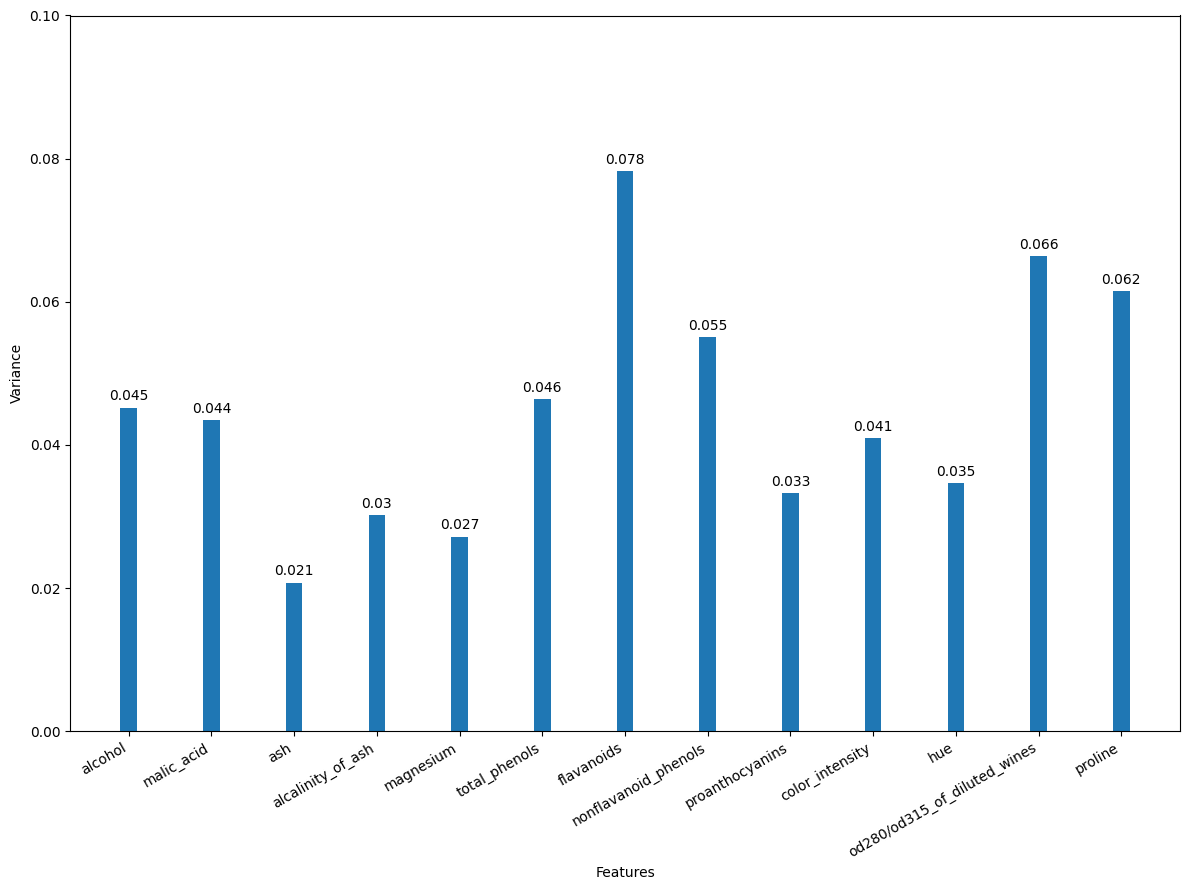

In [ ]:
fig, ax = plt.subplots()

x = X.columns
y = scaled_X_train_v1.var(axis=0)

ax.bar(x, y, width=0.2)
ax.set_xlabel('Features')
ax.set_ylabel('Variance')
ax.set_ylim(0, 0.1)

for index, value in enumerate(y):
    plt.text(x=index, y=value+0.001, s=str(round(value, 3)), ha='center')

fig.autofmt_xdate()
plt.tight_layout()

In [ ]:
sel_X_train_v1 = X_train_v1.drop(['ash', 'magnesium'], axis=1)
sel_X_test_v1 = X_test_v1.drop(['ash', 'magnesium'], axis=1)

gbc.fit(sel_X_train_v1, y_train)

var_preds = gbc.predict(sel_X_test_v1)

f1_score_var = round(f1_score(y_test_v1, var_preds, average='weighted'), 3)

print(f1_score_var)

0.963


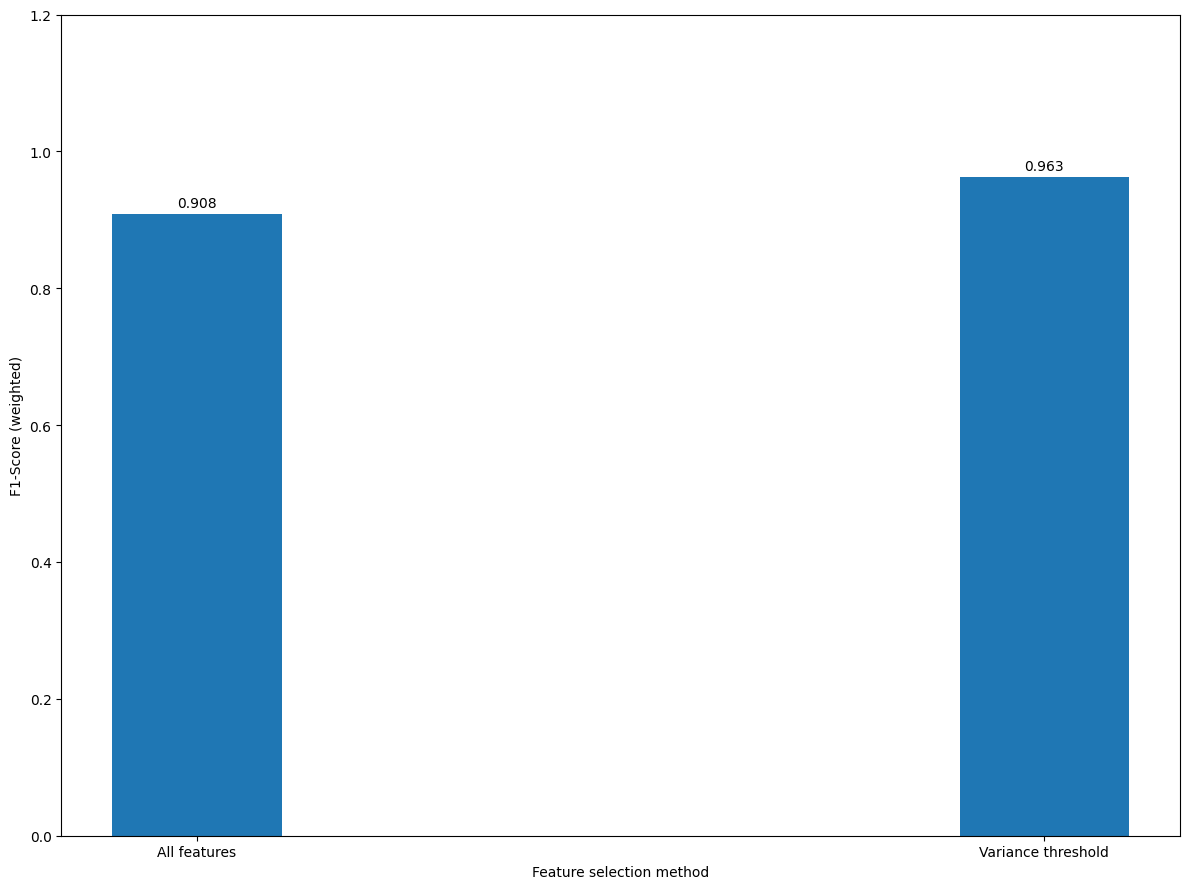

In [ ]:
fig, ax = plt.subplots()

x = ['All features', 'Variance threshold']
y = [f1_score_all, f1_score_var]

ax.bar(x, y, width=0.2)
ax.set_xlabel('Feature selection method')
ax.set_ylabel('F1-Score (weighted)')
ax.set_ylim(0, 1.2)

for index, value in enumerate(y):
    plt.text(x=index, y=value+0.01, s=str(round(value,3)), ha='center')

plt.tight_layout()

## K-best features

In [ ]:
X_train_v2, X_test_v2, y_train_v2, y_test_v2 = X_train.copy(), X_test.copy(), y_train.copy(), y_test.copy()

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif

f1_score_list = []

for k in range(1, 14):
    selector = SelectKBest(mutual_info_classif, k=k)
    selector.fit(X_train_v2, y_train_v2)

    sel_X_train_v2 = selector.transform(X_train_v2)
    sel_X_test_v2 = selector.transform(X_test_v2)

    gbc.fit(sel_X_train_v2, y_train_v2)
    kbest_preds = gbc.predict(sel_X_test_v2)

    f1_score_kbest = round(f1_score(y_test_v2, kbest_preds, average='weighted'), 3)

    f1_score_list.append(f1_score_kbest)

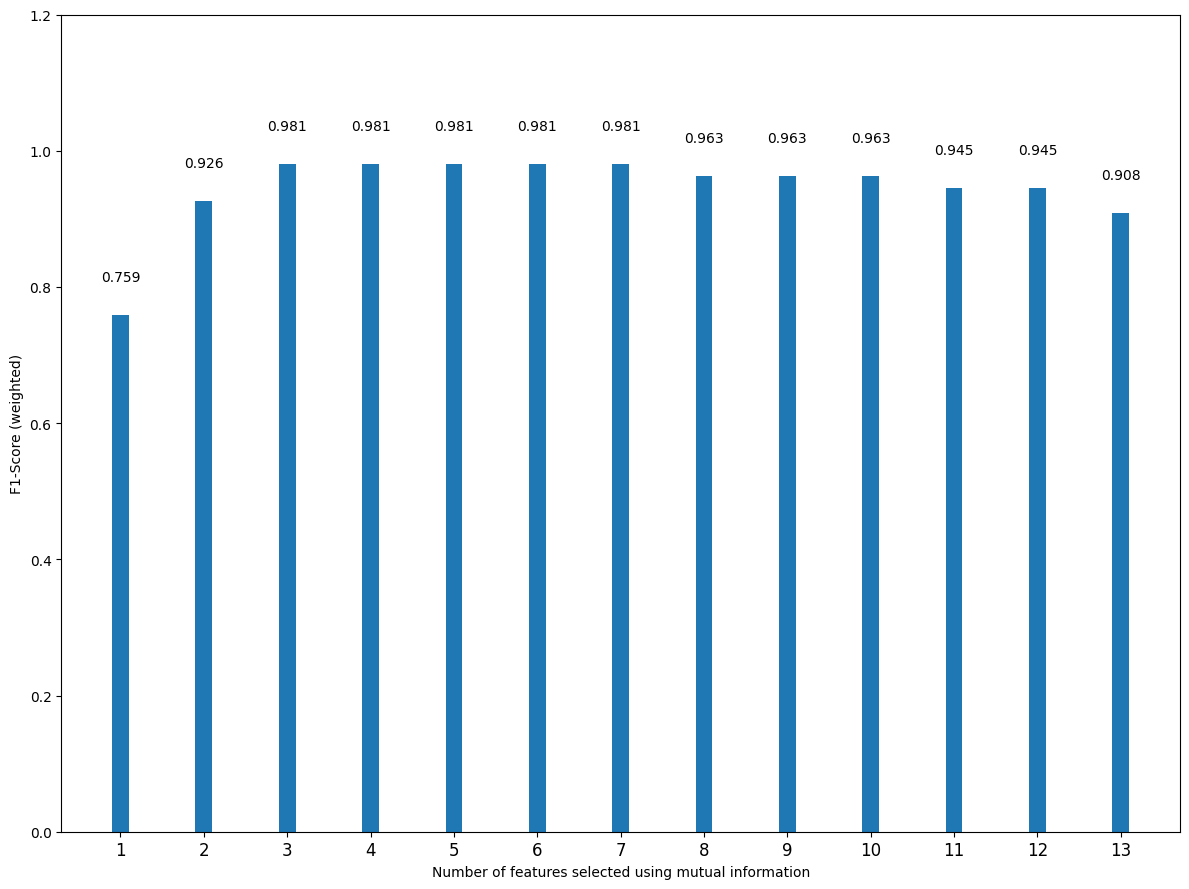

In [ ]:
fig, ax = plt.subplots()

x = np.arange(1, 14)
y = f1_score_list

ax.bar(x, y, width=0.2)
ax.set_xlabel('Number of features selected using mutual information')
ax.set_ylabel('F1-Score (weighted)')
ax.set_ylim(0, 1.2)
ax.set_xticks(np.arange(1, 14))
ax.set_xticklabels(np.arange(1, 14), fontsize=12)

for i, v in enumerate(y):
    plt.text(x=i+1, y=v+0.05, s=str(v), ha='center')

plt.tight_layout()

In [ ]:
selector = SelectKBest(mutual_info_classif, k=3)
selector.fit(X_train_v2, y_train_v2)

selected_feature_mask = selector.get_support()

selected_features = X_train_v2.columns[selected_feature_mask]

selected_features

Index(['flavanoids', 'color_intensity', 'proline'], dtype='object')

## Recursive feature elimination (RFE)

In [ ]:
X_train_v3, X_test_v3, y_train_v3, y_test_v3 = X_train.copy(), X_test.copy(), y_train.copy(), y_test.copy()

In [ ]:
from sklearn.feature_selection import RFE

rfe_f1_score_list = []

for k in range(1, 14):
    RFE_selector = RFE(estimator=gbc, n_features_to_select=k, step=1)
    RFE_selector.fit(X_train_v3, y_train_v3)

    sel_X_train_v3 = RFE_selector.transform(X_train_v3)
    sel_X_test_v3 = RFE_selector.transform(X_test_v3)

    gbc.fit(sel_X_train_v3, y_train_v3)
    RFE_preds = gbc.predict(sel_X_test_v3)

    f1_score_rfe = round(f1_score(y_test_v3, RFE_preds, average='weighted'), 3)

    rfe_f1_score_list.append(f1_score_rfe)

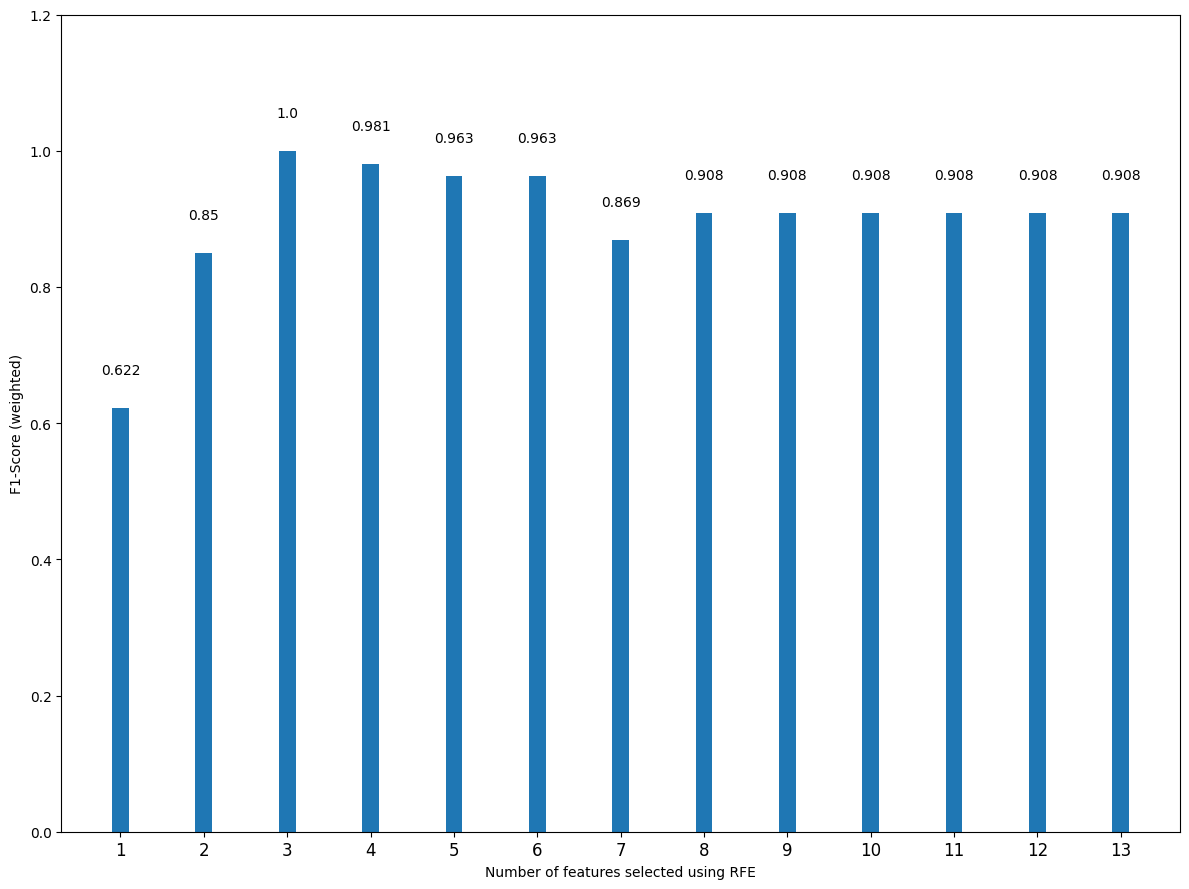

In [ ]:
fig, ax = plt.subplots()

x = np.arange(1, 14)
y = rfe_f1_score_list

ax.bar(x, y, width=0.2)
ax.set_xlabel('Number of features selected using RFE')
ax.set_ylabel('F1-Score (weighted)')
ax.set_ylim(0, 1.2)
ax.set_xticks(np.arange(1, 14))
ax.set_xticklabels(np.arange(1, 14), fontsize=12)

for i, v in enumerate(y):
    plt.text(x=i+1, y=v+0.05, s=str(v), ha='center')

plt.tight_layout()

In [ ]:
RFE_selector = RFE(estimator=gbc, n_features_to_select=3, step=10)
RFE_selector.fit(X_train_v3, y_train_v3)

selected_features_mask = RFE_selector.get_support()

selected_features = X_train_v3.columns[selected_features_mask]
selected_features

Index(['color_intensity', 'od280/od315_of_diluted_wines', 'proline'], dtype='object')

## Decision Tree

In [ ]:
X_train_v4, X_test_v4, y_train_v4, y_test_v4 = X_train.copy(), X_test.copy(), y_train.copy(), y_test.copy()

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectFromModel

dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train_v4, y_train_v4)

threshold = 0.02
selector = SelectFromModel(dt, threshold=threshold, prefit=True)
sel_X_train_v4 = selector.transform(X_train_v4)
sel_X_test_v4 = selector.transform(X_test_v4)

gbc = GradientBoostingClassifier(random_state=42)
gbc.fit(sel_X_train_v4, y_train_v4)
gbc_preds = gbc.predict(sel_X_test_v4)

dt_f1_score = round(f1_score(y_test_v4, gbc_preds, average='weighted'), 3)
print(f"F1 Score with Gradient Boosting Classifier on selected features: {dt_f1_score}")

selected_features_mask = selector.get_support()
selected_features = X_train_v4.columns[selected_features_mask]
print("Selected features:", list(selected_features))



/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


F1 Score with Gradient Boosting Classifier on selected features: 0.982
Selected features: ['malic_acid', 'ash', 'alcalinity_of_ash', 'flavanoids', 'color_intensity', 'od280/od315_of_diluted_wines', 'proline']


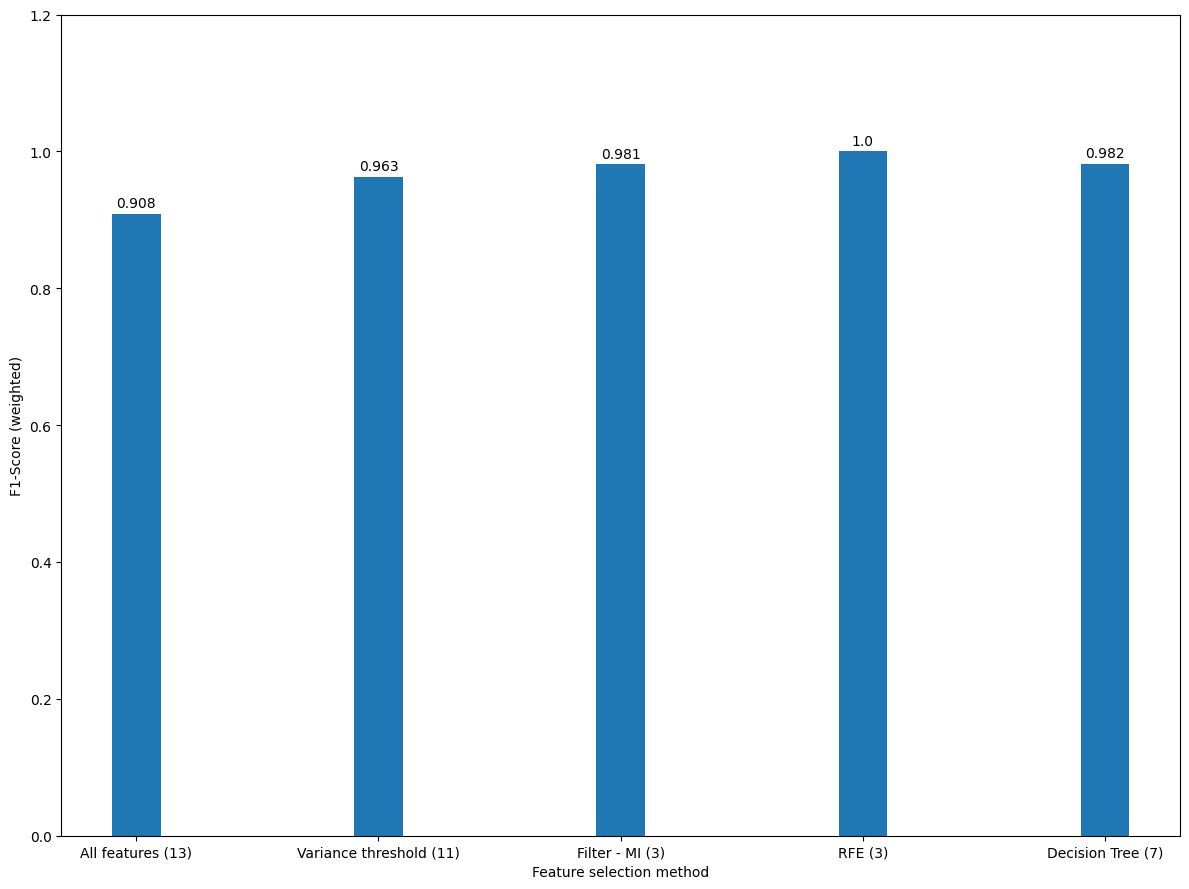

In [ ]:
fig, ax = plt.subplots()

x = ['All features (13)', 'Variance threshold (11)', 'Filter - MI (3)', 'RFE (3)', 'Decision Tree (7)']
y = [f1_score_all, f1_score_var, 0.981, 1.0, dt_f1_score]

ax.bar(x, y, width=0.2)
ax.set_xlabel('Feature selection method')
ax.set_ylabel('F1-Score (weighted)')
ax.set_ylim(0, 1.2)

for i, v in enumerate(y):
    plt.text(x=i, y=v+0.01, s=str(v), ha='center')

plt.tight_layout()